In [2]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from ESRNN import ESRNN
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Data Preparation for the model

In [3]:
elect = pd.read_excel("hourly_electricity.xlsx")
elect["date"] = pd.to_datetime(elect["date"], format='%d.%m.%Y')

In [4]:
elect.head()

,date,hour,electricity
0,2017-01-01,00:00:00,27223.06
1,2017-01-01,01:00:00,25825.90
2,2017-01-01,02:00:00,24252.68
3,2017-01-01,03:00:00,22915.47
4,2017-01-01,04:00:00,22356.99


In [5]:
#create an hourly date column
elect["time"] = elect["date"].astype(str) + " " + elect["hour"].astype(str)
elect["time"] = pd.to_datetime(elect["time"])
elect.sort_values(by = "time", inplace = True)
#elect.set_index("time", inplace=True)
elect.drop(columns=["hour", "date"], inplace = True)

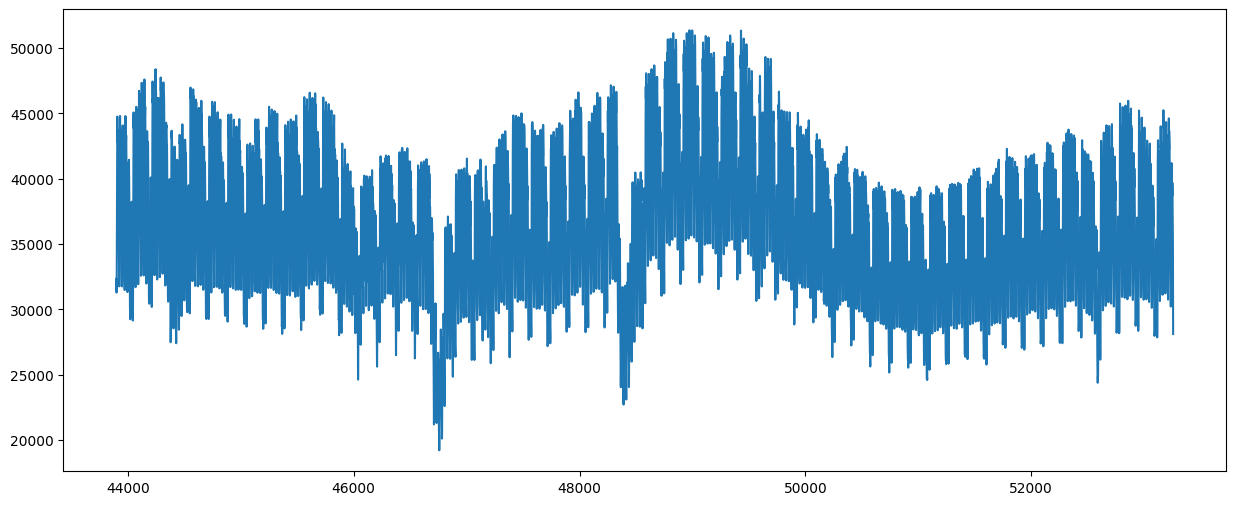

In [6]:
fig, ax = plt.subplots(figsize = (15, 6))
ax.plot(elect.index[-390*24:], elect["electricity"][-390*24:], label = "hourly  electricity consumption")
plt.show()

c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


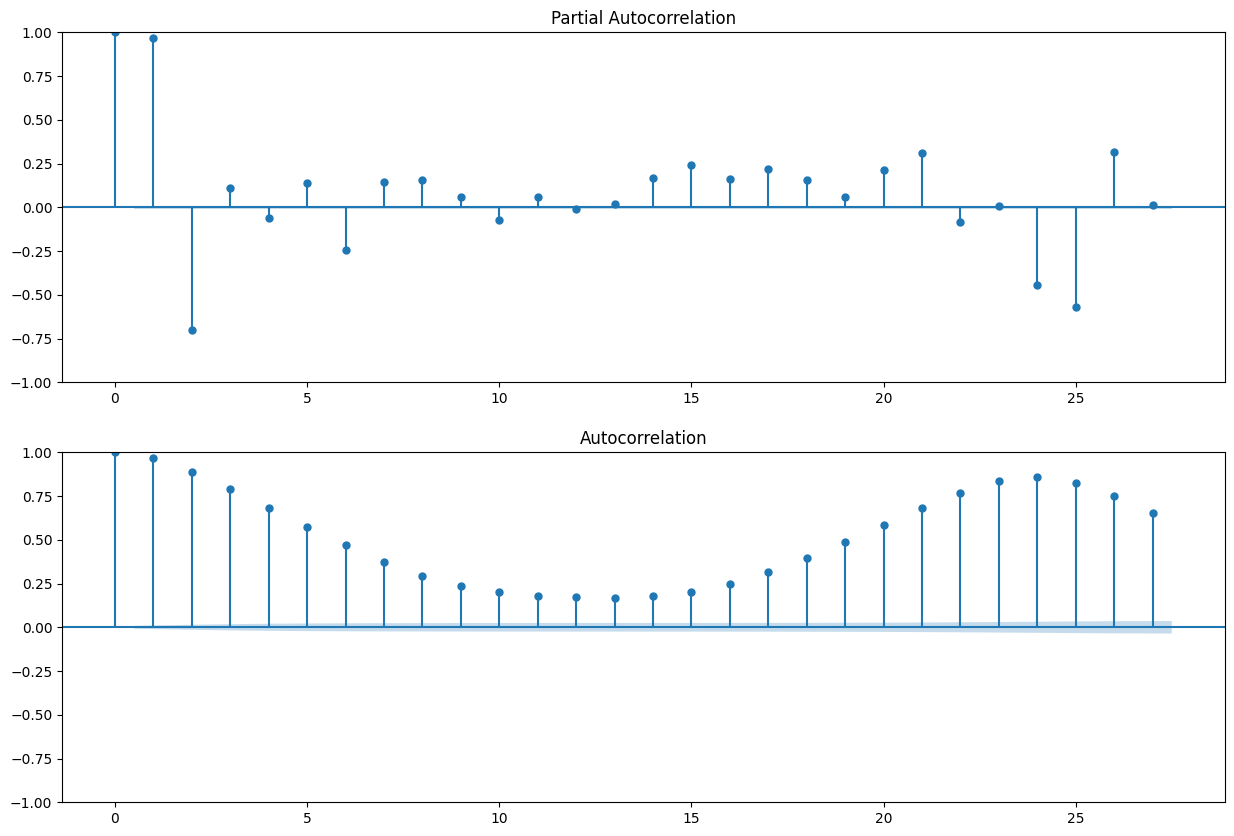

In [7]:
fig, ax = plt.subplots(2, 1, figsize = (15,10))

plot_pacf(elect["electricity"],ax = ax[0], lags = 27) # It seems that there are significant spikes until 26
plot_acf(elect["electricity"],ax = ax[1], lags = 27);

In [8]:
elect.reset_index(inplace=True)

In [9]:
elect.rename(columns={"index":'unique_id', "electricity":"y", "time":"ds"}, inplace = True)

In [10]:
elect["unique_id"] = "demand"

In [11]:
elect["x"] = elect["ds"].dt.month_name() # months are added as dummy regressor to capture yearly seasonality too

In [12]:
elect["y"] = elect["y"].astype(np.float32)

In [13]:
train = elect[elect["ds"]<"2023-01-01"]
test = elect[(elect["ds"]>="2023-01-01") & (elect["ds"]<"2023-01-21")]

In [14]:
X_train = train[["unique_id", "ds", "x"]]
Y_train = train[["unique_id", "ds", "y"]]

X_test = test[["unique_id", "ds", "x"]]
Y_test = test[["unique_id", "ds", "y"]]
Y_test['y_hat_naive2'] = Y_test["y"].mean() # the mean of the TS is added so that the model will evaluate predictions on 
#the test data because the model reguires y_hat_naive2 as benchmark predictions to evaluate the model


## Modeling the data and the prediction

In [23]:
model = ESRNN(max_epochs=34 , batch_size=1, freq_of_test=1, seasonality=[24,168], 
              dilations=[[2,3], [24, 168]], input_size=168, output_size=480,
              learning_rate = 0.01, device='cpu')

In [24]:
model.fit(X_train, Y_train, X_test, Y_test)

Infered frequency: H
=============== Training ESRNN  ===============

========= Epoch 0 finished =========
Training time: 33.34102
Training loss (50 prc): 0.06154
Testing loss  (50 prc): 0.04891
OWA: 1.347 
SMAPE: 18.261 
MASE: 3.329 
========= Epoch 1 finished =========
Training time: 34.01495
Training loss (50 prc): 0.05265
Testing loss  (50 prc): 0.03909
OWA: 1.263 
SMAPE: 17.05 
MASE: 3.137 
========= Epoch 2 finished =========
Training time: 34.08186
Training loss (50 prc): 0.04245
Testing loss  (50 prc): 0.03198
OWA: 1.193 
SMAPE: 16.028 
MASE: 2.976 
========= Epoch 3 finished =========
Training time: 33.97136
Training loss (50 prc): 0.03513
Testing loss  (50 prc): 0.02707
OWA: 1.143 
SMAPE: 15.312 
MASE: 2.858 
========= Epoch 4 finished =========
Training time: 33.59617
Training loss (50 prc): 0.03003
Testing loss  (50 prc): 0.02388
OWA: 1.087 
SMAPE: 14.55 
MASE: 2.724 
========= Epoch 5 finished =========
Training time: 33.85573
Training loss (50 prc): 0.02669
Testing loss  

In [25]:
yhat = model.predict(X_test)

In [27]:
test_vs_pred =  pd.merge(Y_test, yhat[["ds", "y_hat"]], on="ds", how="left")

In [29]:
np.mean(abs(test_vs_pred["y"]-test_vs_pred["y_hat"])*100/test_vs_pred["y"])

4.4848046655453055

In [ ]:
# achieved 4.5% error rate with ES-RNN for 480 hours multi-step forecasting !!!

In [33]:
#Let's check the forecasted values (y_hat) of the first 24 hours
test_vs_pred.head(24)

,unique_id,ds,y,y_hat_naive2,y_hat
0,demand,2023-01-01 00:00:00,28816.550781,37133.957031,27591.917969
1,demand,2023-01-01 01:00:00,27589.250000,37133.957031,26838.824219
2,demand,2023-01-01 02:00:00,26328.820312,37133.957031,26273.869141
3,demand,2023-01-01 03:00:00,25224.400391,37133.957031,25568.017578
4,demand,2023-01-01 04:00:00,24636.460938,37133.957031,25024.830078
5,demand,2023-01-01 05:00:00,24376.009766,37133.957031,25106.994141
6,demand,2023-01-01 06:00:00,24487.640625,37133.957031,26646.712891
7,demand,2023-01-01 07:00:00,24861.349609,37133.957031,25980.957031
8,demand,2023-01-01 08:00:00,24809.380859,37133.957031,26412.513672
9,demand,2023-01-01 09:00:00,26314.849609,37133.957031,27995.808594


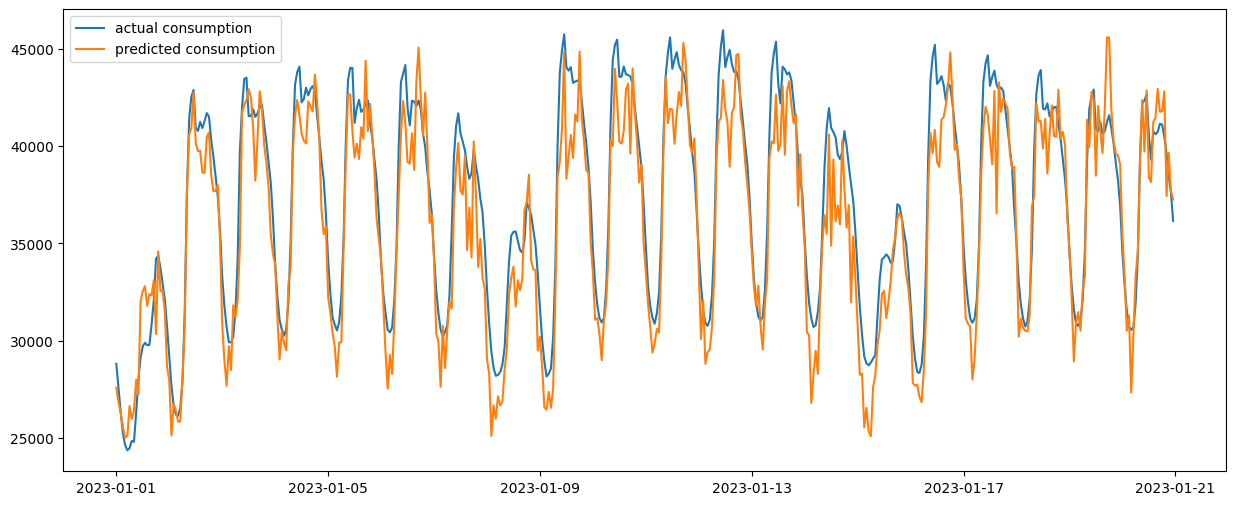

In [30]:
fig, ax = plt.subplots(figsize = (15,6))
ax.plot(test_vs_pred["ds"], test_vs_pred["y"], label = "actual consumption", color = "C0")
ax.plot(test_vs_pred["ds"], test_vs_pred["y_hat"], label = "predicted consumption", color = "C1")
plt.legend(loc="upper left")
plt.show()